# <center>互评作业三：基于 K-means 的文本聚类<center>

# <center>1120193405   许阳霄   07111908班<center>

GitHub地址为：https://github.com/Xuyangxiao0604/BIT-Datamining-homework3

## 一、数据预处理

（1）读取数据

In [1]:
import glob

# 数据路径
data_path = '20_newsgroups'

# 得到文本数据路径数据
classes_dir_path = glob.glob(data_path + '/*')
classes_txt_names = []
for item in classes_dir_path:
    classes_txt_names.append(glob.glob(item + '/*'))

# 读取数据
data = []
for c_txt_names in classes_txt_names:
    c_data = []
    for txt_name in c_txt_names:
        c_data.append(open(txt_name, errors='ignore').read())
    data.append(c_data)

（2）预处理

去除停用词、数字、符号等，提取文本特征。

In [2]:
import re
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    # 缩写替换
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"cannot", "can not ", text)
    text = re.sub(r"what\'s", "what is", text)
    text = re.sub(r"What\'s", "what is", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve ", " have ", text)
    text = re.sub(r"n\'t", " not ", text)
    text = re.sub(r"i\'m", "i am ", text)
    text = re.sub(r"I\'m", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    # 单独的数字替换为英文
    text = re.sub(r" 1 ", " one ", text)
    text = re.sub(r" 2 ", " two ", text)
    text = re.sub(r" 3 ", " three ", text)
    text = re.sub(r" 4 ", " four ", text)
    text = re.sub(r" 5 ", " five ", text)
    text = re.sub(r" 6 ", " six ", text)
    text = re.sub(r" 7 ", " seven ", text)
    text = re.sub(r" 8 ", " eight ", text)
    text = re.sub(r" 9 ", " nine ", text)
    # 替换不可见字符以及各分隔符
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\\+', ' ', text)
    text = re.sub(r'/+', ' ', text)
    text = re.sub(r'_+', ' ', text)
    text = re.sub(r'--+', ' ', text)
    text = re.sub(r'\.', ' ', text)
    text = re.sub(r' +', ' ', text)

    return text

# 分词
def tokenize(text):
    token_words = word_tokenize(text)
    token_words = pos_tag(token_words)
    return token_words

# 去掉词性
def stem(token_words):
    wordnet_lematizer = WordNetLemmatizer()
    words_lematizer = []
    for word, tag in token_words:
        if tag.startswith('NN'):
            word_lematizer = wordnet_lematizer.lemmatize(word, pos='n')  # n代表名词
        elif tag.startswith('VB'):
            word_lematizer = wordnet_lematizer.lemmatize(word, pos='v')  # v代表动词
        elif tag.startswith('JJ'):
            word_lematizer = wordnet_lematizer.lemmatize(word, pos='a')  # a代表形容词
        elif tag.startswith('R'):
            word_lematizer = wordnet_lematizer.lemmatize(word, pos='r')  # r代表代词
        else:
            word_lematizer = wordnet_lematizer.lemmatize(word)
        words_lematizer.append(word_lematizer)
    return words_lematizer

# 去掉停用词
def delete_stopwords(token_words):
    """ 去停用词"""
    sr = stopwords.words('english')
    cleaned_words = [word for word in token_words if word not in sr]
    return cleaned_words

# 去掉数字
def is_number(s):
    """ 判断字符串是否为数字"""
    try:
        float(s)
        return True
    except ValueError:
        pass
    try:
        import unicodedata
        unicodedata.numeric(s)
        return True
    except (TypeError, ValueError):
        pass
    return False

# 删除特殊字符
def delete_characters(token_words):
    """去除特殊字符、数字"""
    characters = ['\'', "''", '``', ',', '.', ':', ';', '?', '(', ')', '[', ']', '&',
                  '!', '*', '@', '#', '$', '%', '-', '>', '<', '...', '^', '{', '}']
    words_list = [word for word in token_words if word not in characters and not is_number(word)]
    return words_list

# 全部转换为小写
def to_lower(token_words):
    words_lists = [x.lower() for x in token_words]
    return words_lists

# 文本预处理接口
def pre_process(text):
    text = clean_text(text)
    token_words = tokenize(text)
    token_words = stem(token_words)
    token_words = delete_stopwords(token_words)
    token_words = delete_characters(token_words)
    token_words = to_lower(token_words)
    return token_words

# 数据预处理
docs_feats = []  # 每个文档清洗后的字符串数据
words_set = set()  # 整个数据集的词集合
k = 1
for c_doc in data:
    print('\r', end='')
    print('{} / {}'.format(k, len(data)))
    for doc in c_doc:
        words = pre_process(doc)
        for word in words:
            words_set.add(word)
        docs_feats.append(' '.join(words))
    k += 1
print('数据集中出现的词共有 %d个' % len(words_set))


1 / 20
2 / 20
3 / 20
4 / 20
5 / 20
6 / 20
7 / 20
8 / 20
9 / 20
10 / 20
11 / 20
12 / 20
13 / 20
14 / 20
15 / 20
16 / 20
17 / 20
18 / 20
19 / 20
20 / 20
数据集中出现的词共有 241960个


## 二、 特征向量化和K-means 模型训练

将预处理后的文本使用 TF-IDF 方法进行向量化。然后根据设定的 K 值，构建 K-means 模型，并对向量化的文本数据进行聚类。

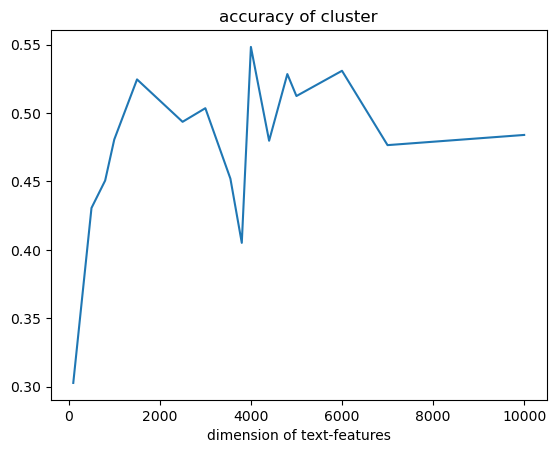

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 搜索最佳得文本特征维度
num_features = [100, 500, 800, 1000, 1500, 2500, 3000, 3550, 3800, 4000, 4400, 4800, 5000, 6000, 7000, 10000]
accuracy = []
for i in range(len(num_features)):
    num_feature = num_features[i]
    # 计算每个文档的TFIDF特征值
    vectorizer_tfidf = TfidfVectorizer(max_features=num_feature)
    docs_feats_tfidf = vectorizer_tfidf.fit_transform(docs_feats).toarray()
    # k-means聚类 将文档的特征空间分为20类
    k_means = KMeans(n_clusters=20, random_state=14, init='k-means++', n_init='auto')
    # 迭代并预测
    pred = k_means.fit_predict(docs_feats_tfidf)
    # 估计分类准确度
    slice = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 15997,
             16997, 17997, 18997, 19997]
    correct = 0
    for i in range(len(slice) - 1):
        correct += np.max(np.unique(pred[slice[i]:slice[i + 1]], return_counts=True)[1])
    accuracy.append(correct / len(pred))
# 画出准确度随着而往那边特征维数的变化曲线
plt.figure()
plt.title('accuracy of cluster')
plt.xlabel('dimension of text-features')
plt.plot(num_features, accuracy)
plt.show(block=True)

## 三、聚类结果分析

使用CH指数方法评估聚类结果。

In [4]:
# 取最好得结果算CH_score
vectorizer_tfidf = TfidfVectorizer(max_features=3550)
docs_feats_tfidf = vectorizer_tfidf.fit_transform(docs_feats).toarray()
k_means = KMeans(n_clusters=20, random_state=14, init='k-means++', n_init='auto')
pred = k_means.fit_predict(docs_feats_tfidf)
ch_score = calinski_harabasz_score(docs_feats_tfidf, pred)
print('CH-score:', ch_score)

CH-score: 84.07148807126957


## 四、可视化

使用PCA降维方法将高维数据降维至2D或3D，然后进行可视化，观察聚类效果。

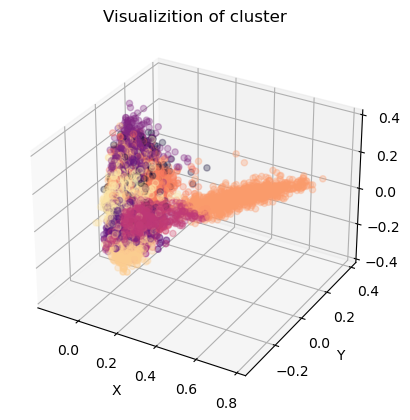

In [5]:
# PCA算法降低维度方便可视化
pca = PCA(n_components=3)
visualizition = pca.fit_transform(docs_feats_tfidf)

# 将结果可视化
x = np.array(visualizition[:, 0])
y = np.array(visualizition[:, 1])
z = np.array(visualizition[:, 2])

ax = plt.subplot(projection='3d')
ax.set_title('Visualizition of cluster')
ax.scatter(x, y, z, c=[pred], cmap='magma', alpha=0.3)  # 绘制三维数据点
# 设置坐标轴
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show(block=True)